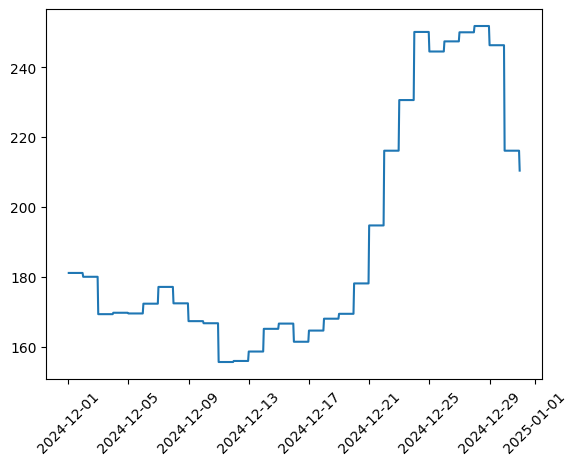

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import urllib
import re

OMNI_ROOT = os.environ.get("OMNI_ROOT", "./omni")
omni_lowres_cache = {}

def get_f107_single(dt):
    """
    Return the float f10.7 value the hour indicated by datetime dt

    Format of the omni files this queries:
    https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2.text

    :param dt: datetime for which to calculate f10.7 value
    :return: f10.7 value for dt
    """
    omni_disk_file = os.path.join(OMNI_ROOT, "low_res_omni", "omni2_{}.dat".format(dt.year))
    if dt.year in omni_lowres_cache.keys():
        # check if we've requested this before and it's in the cache
        data = omni_lowres_cache[dt.year]
    elif os.path.exists(omni_disk_file):
        with open(omni_disk_file, "r") as f:
            data = f.read()
    else:
        # otherwise, must request, note: save to cache
        url = "https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_{}.dat".format(dt.year)
        data = omni_lowres_cache[dt.year] = urllib.request.urlopen(url).read().decode()
        if not os.path.exists(os.path.dirname(omni_disk_file)):
            os.makedirs(os.path.dirname(omni_disk_file))
        with open(omni_disk_file, "w") as f:
            f.writelines(data)

    doy = str(int(dt.strftime("%j")))  # %j gives 0 padded to three digits, omni does not 0 pad.
    pattern = re.compile(
        # year                doy                        hour  everthing else
        str(dt.year) + "\s+" + doy + "\s+" + str(dt.hour) + ".*"
    )
    m = pattern.search(data)
    # import ipdb; ipdb.set_trace()
    if m:
        #                         OMNI2_YYYY.DAT FORMAT DESCRIPTION
        # WORD  FORMAT  Fill Value         MEANING                  UNITS/COMMENTS
        # 1 ...
        # ...
        # 51       F6.1 999.9    f10.7_index                  ( sfu = 10-22W.m-2.Hz-1)
        # ...
        # so f10.7 is the 50th word starting from 0
        return float(m.group().split()[50])
    else:
        # just return np.nan and use nanmean when needed so that we
        # can still get a final value without worrying too much about missing data.
        return np.nan


#dt = datetime.datetime(2024,12,24,12,12,0)
start = datetime.datetime(2024,12,1,0,0,0)
f107_vec = []
dt_vec = []
time=start
for ihour in range(30*24):
  time = time + datetime.timedelta(hours=1.)
  #time = start + datetime.timedelta(hours=ihour)
  #print(time)
  f107_vec.append(get_f107_single(time))
  dt_vec.append(time)

plt.xticks(rotation=45)
plt.plot(dt_vec,f107_vec)

In [ ]:
import pandas as pd
from google.colab import files
from google.colab import drive
import os
import datetime
import urllib.request
import re
import numpy as np
import matplotlib.pyplot as plt
OMNI_ROOT = os.environ.get("OMNI_ROOT", "./omni")
omni_lowres_cache = {}

# Mount Google Drive
drive.mount('/content/drive')
print(os.listdir('/content/drive'))

drive_folder = "/content/drive/MyDrive/CNN_SDO/"

os.makedirs('/content/drive/MyDrive/CNN_SDO', exist_ok=True)

def get_omni_value(dt, col_idx):
    omni_disk_file = os.path.join(OMNI_ROOT, "low_res_omni", "omni2_{}.dat".format(dt.year))
    if dt.year in omni_lowres_cache.keys():
        data = omni_lowres_cache[dt.year]
    elif os.path.exists(omni_disk_file):
        with open(omni_disk_file, "r") as f:
            data = f.read()
    else:
        url = "https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/omni2_{}.dat".format(dt.year)
        data = omni_lowres_cache[dt.year] = urllib.request.urlopen(url).read().decode()
        if not os.path.exists(os.path.dirname(omni_disk_file)):
            os.makedirs(os.path.dirname(omni_disk_file))
        with open(omni_disk_file, "w") as f:
            f.writelines(data)

    doy = str(int(dt.strftime("%j")))
    pattern = re.compile(str(dt.year) + "\s+" + doy + "\s+" + str(dt.hour) + ".*")
    m = pattern.search(data)
    if m:
        try:
            return float(m.group().split()[col_idx])
        except:
            return np.nan
    else:
        return np.nan



start = datetime.datetime(2024,1,1,0,0,0)


dt_vec = []
f107_vec = []
kp_vec = []
dst_vec = []
sunspot_vec = []

# 152 days
time = start
for ihour in range(152*24):
    time = time + datetime.timedelta(hours=1)
    # Only collect data at 6:00, 12:00, and 18:00
    if time.hour in [6, 12, 18]:
        dt_vec.append(time)
        f107_vec.append(get_omni_value(time, 50))   # F10.7
        kp_vec.append(get_omni_value(time, 38))     # Kp
        dst_vec.append(get_omni_value(time, 40))    # Dst
        sunspot_vec.append(get_omni_value(time, 39))# Sunspot
'''
time = start
for ihour in range(30*24):
    time = time + datetime.timedelta(hours=1)
    dt_vec.append(time)
    f107_vec.append(get_omni_value(time, 50))  # F10.7
    kp_vec.append(get_omni_value(time, 38))    # Kp
    dst_vec.append(get_omni_value(time, 40))   # Dst
    sunspot_vec.append(get_omni_value(time, 39)) # Sunspot
'''

df_all = pd.DataFrame({
    'datetime': dt_vec,
    'f107': f107_vec,
    'kp': kp_vec,
    'dst': dst_vec,
    'sunspot': sunspot_vec
})
df_all.to_csv(f"{drive_folder}/omni_timeseries1.csv", index=False)


'''
# F10.7 speichern
df_f107 = pd.DataFrame({'datetime': dt_vec, 'f107': f107_vec})
df_f107.to_csv('f107_timeseries.csv', index=False)
files.download('f107_timeseries.csv')

# Kp speichern
df_kp = pd.DataFrame({'datetime': dt_vec, 'kp': kp_vec})
df_kp.to_csv('kp_timeseries.csv', index=False)
files.download('kp_timeseries.csv')

# Dst speichern
df_dst = pd.DataFrame({'datetime': dt_vec, 'dst': dst_vec})
df_dst.to_csv('dst_timeseries.csv', index=False)
files.download('dst_timeseries.csv')

df_sunspot = pd.DataFrame({'datetime': dt_vec, 'sunspot': sunspot_vec})
df_sunspot.to_csv('sunspot_timeseries.csv', index=False)
files.download('sunspot_timeseries.csv')

plt.plot(dt_vec, sunspot_vec)
plt.xticks(rotation=45)
'''



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']


"\n# F10.7 speichern\ndf_f107 = pd.DataFrame({'datetime': dt_vec, 'f107': f107_vec})\ndf_f107.to_csv('f107_timeseries.csv', index=False)\nfiles.download('f107_timeseries.csv')\n\n# Kp speichern\ndf_kp = pd.DataFrame({'datetime': dt_vec, 'kp': kp_vec})\ndf_kp.to_csv('kp_timeseries.csv', index=False)\nfiles.download('kp_timeseries.csv')\n\n# Dst speichern\ndf_dst = pd.DataFrame({'datetime': dt_vec, 'dst': dst_vec})\ndf_dst.to_csv('dst_timeseries.csv', index=False)\nfiles.download('dst_timeseries.csv')\n\ndf_sunspot = pd.DataFrame({'datetime': dt_vec, 'sunspot': sunspot_vec})\ndf_sunspot.to_csv('sunspot_timeseries.csv', index=False)\nfiles.download('sunspot_timeseries.csv')\n\nplt.plot(dt_vec, sunspot_vec)\nplt.xticks(rotation=45)\n"

(array([20058., 20062., 20066., 20070., 20074., 20078., 20082., 20086.,
        20089.]),
 [Text(20058.0, 0, '2024-12-01'),
  Text(20062.0, 0, '2024-12-05'),
  Text(20066.0, 0, '2024-12-09'),
  Text(20070.0, 0, '2024-12-13'),
  Text(20074.0, 0, '2024-12-17'),
  Text(20078.0, 0, '2024-12-21'),
  Text(20082.0, 0, '2024-12-25'),
  Text(20086.0, 0, '2024-12-29'),
  Text(20089.0, 0, '2025-01-01')])

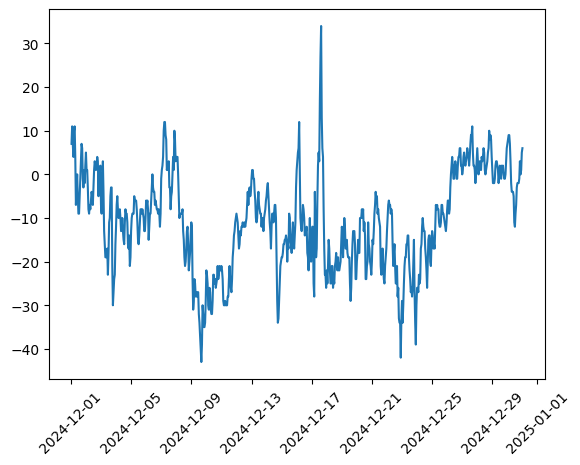

In [ ]:
plt.plot(dt_vec, dst_vec)
plt.xticks(rotation=45)

In [ ]:
!pip install "sunpy[all]"
!pip install astropy

import sunpy.map
from sunpy.net import Fido, attrs as a
import astropy.units as u


result = Fido.search(a.Time('2025-07-01', '2025-07-02'), a.Instrument('AIA'), a.Wavelength(171*u.angstrom))
downloaded_files = Fido.fetch(result)
maps = [sunpy.map.Map(file) for file in downloaded_files]

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
    session = self.get_default_session(options)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 71, in get_default_session
    self._session = self.enter_context(self._build_session(options))
                                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/index_command.py", line 100, in _build_session
    session = PipSession(
              ^^^^^^^^^

KeyboardInterrupt: 